In [165]:
import graphviz
import pandas as pd
import numpy as np
import tflscripts
import pickle

configuration = tflscripts.read_configuration()
df = pd.read_pickle('results.p')
len(df)

32842

In [166]:
df = df.loc[df.accuracy_negative >= 0.95]
df = df.loc[df.accuracy_positive >= 0.75]
df = df.loc[df.type_of_transfer != 'No transfer']

In [167]:
df_transfers = df[['source_device_name', 'target_device_name', 'source_dataset', 'target_dataset', 'label']]
df_transfers = df_transfers.drop_duplicates()
df_transfers.label.unique()

array(['Chopping food', 'Dishes', 'Microwave door closed',
       'Microwave button press', 'Knocking', 'Microwave', 'Conversation',
       'Alarm', 'Cupboard door closed', 'Microwave done chime',
       'Vacuum cleaning', 'Blender running', 'Kettle',
       'Cupboard door opened', 'Null'], dtype=object)

In [168]:
def key_for(dataset, device_name):
    dataset_key = {
        'robotics-final': 'R1',
        'scott-final-iter1': 'T1',
        'synergy-final-iter1': 'S1',
        'synergy-final-iter2': 'S2',
        'synergy-final-iter4': 'S3',
        'synergy-final-iter5': 'S4',
    }[dataset]
    
    device_split = device_name.split(' ')
    placement = device_split[2]
    placement_key = placement[0]
    if dataset == 'robotics-final':
        placement_key = {'Coffee': 'O', 'Sink': 'I', 'Entrance': 'E'}[placement]
    
    device_key = device_split[0][0] + device_split[1]
    
    return '-'.join([dataset_key, placement_key, device_key])

In [169]:
df_transfers['source'] = [key_for(r['source_dataset'], r['source_device_name']) for _, r in df_transfers.iterrows()]
df_transfers['target'] = [key_for(r['target_dataset'], r['target_device_name']) for _, r in df_transfers.iterrows()]

In [191]:
def get_transfer_counts(activity):
    filtered = df_transfers.loc[df_transfers.label == activity]

    transfer_counts = filtered[['source', 'target', 'source_dataset']].groupby(['source', 'target']).agg(['count']).reset_index()
    transfer_counts.columns = ['source', 'target', 'count']

    return transfer_counts

def full_graph(activity):
    transfer_counts = get_transfer_counts(activity)

    d = graphviz.Digraph()

    colors = {'C': 'rosybrown1', 'S': 'moccasin', 'T': 'grey80', 'P': 'palegreen3', 'L': 'turquoise', 'R': 'powderblue', 'E': 'grey40', 'O': 'lightsalmon2', 'I': 'tan'}
    shapes = {'R': 'box', 'S': 'ellipse', 'T': 'diamond'}

    nodes = np.unique(df_transfers['source'].values.tolist() + df_transfers['target'].values.tolist())

    clusters = {}
    for space in ['R', 'S', 'T']:
        c = graphviz.Digraph('cluster_' + space)
        c.body.append('style=filled')
        c.body.append('color=lightgrey')
        # c.body.append('label=process')
        c.node_attr.update(style='filled', color='white')
        clusters[space] = c

    for n in nodes:
        if len(transfer_counts.loc[(transfer_counts.source == n) | (transfer_counts.target == n)]) == 0:
            continue

        name_split = n.split('-')
        c = clusters[name_split[0][0]]
        c.node(n, name_split[2], style='filled', fillcolor=colors[name_split[1]], shape=shapes[name_split[0][0]])

    skip = {}
    for n1 in nodes:
        for n2 in nodes:
            if n1 + n2 in skip:
                continue
            skip[n2 + n1] = True

            n1_to_n2 = transfer_counts.loc[(transfer_counts.source == n1) & (transfer_counts.target == n2)]
            n2_to_n1 = transfer_counts.loc[(transfer_counts.source == n2) & (transfer_counts.target == n1)]

            if len(n1_to_n2) > 0 and len(n2_to_n1) > 0:
                d.edge(n1, n2, dir='both', arrowhead='vee', arrowtail='vee')
            elif len(n1_to_n2) > 0:
                d.edge(n1, n2, style='dotted', arrowhead='vee')
            elif len(n2_to_n1) > 0:
                d.edge(n2, n1, style='dotted', arrowhead='vee')

    for space in clusters:
        d.subgraph(clusters[space])

    print(activity)
    return d

def key_to_room_and_location(key):
    name_split = key.split('-')
    return name_split[0][0] + name_split[1][0]

def abstracted_graph(activity):
    transfer_counts = get_transfer_counts(activity)

    aggr_transfer_counts = transfer_counts.copy()
    aggr_transfer_counts['source'] = [key_to_room_and_location(source) for source in aggr_transfer_counts['source']]
    aggr_transfer_counts['target'] = [key_to_room_and_location(target) for target in aggr_transfer_counts['target']]
    aggr_transfer_counts = aggr_transfer_counts.drop_duplicates()

    nodes = np.unique(aggr_transfer_counts['source'].values.tolist() + aggr_transfer_counts['target'].values.tolist())

    d = graphviz.Digraph()

    clusters = {}
    for space in ['R', 'S', 'T']:
        c = graphviz.Digraph('cluster_' + space)
        c.body.append('style=filled')
        c.body.append('color=lightgrey')
        # c.body.append('label=process')
        c.node_attr.update(style='filled', color='white')
        clusters[space] = c

    for n in nodes:
        if len(aggr_transfer_counts.loc[(aggr_transfer_counts.source == n) | (aggr_transfer_counts.target == n)]) == 0:
            continue

        c = clusters[n[0]]
        c.node(n, '', style='filled', fillcolor=colors[n[1]], shape=shapes[n[0]])

    skip = {}
    for n1 in nodes:
        for n2 in nodes:
            if n1 + n2 in skip or n1 == n2:
                continue
            skip[n2 + n1] = True

            n1_to_n2 = aggr_transfer_counts.loc[(aggr_transfer_counts.source == n1) & (aggr_transfer_counts.target == n2)]
            n2_to_n1 = aggr_transfer_counts.loc[(aggr_transfer_counts.source == n2) & (aggr_transfer_counts.target == n1)]

            if len(n1_to_n2) > 0 and len(n2_to_n1) > 0:
                d.edge(n1, n2, dir='both', arrowhead='vee', arrowtail='vee')
            elif len(n1_to_n2) > 0:
                d.edge(n1, n2, style='dotted', arrowhead='vee')
            elif len(n2_to_n1) > 0:
                d.edge(n2, n1, style='dotted', arrowhead='vee')

    # c.edges([built_edges])
    for space in clusters:
        d.subgraph(clusters[space])

    print(activity)
    return d

Dishes


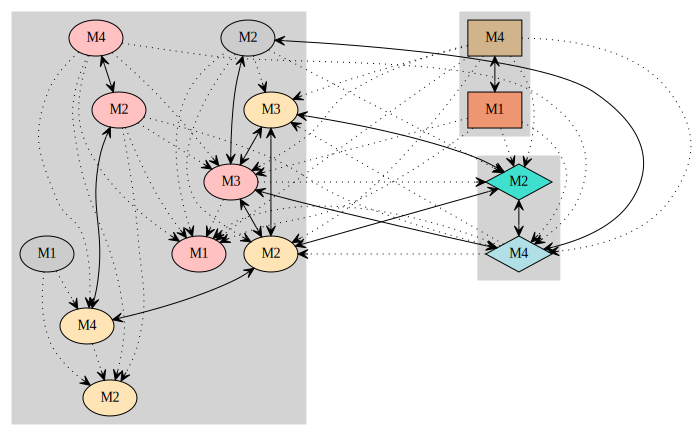

In [197]:
full_graph('Dishes')

Chopping food


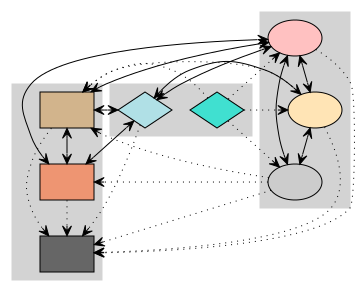

In [188]:
abstracted_graph('Chopping food')

Dishes


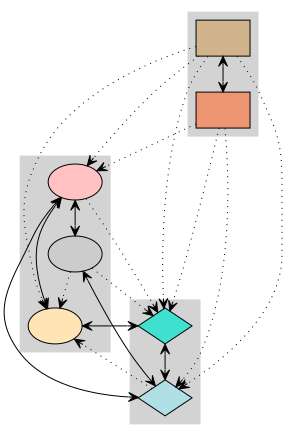

In [189]:
abstracted_graph('Dishes')

Microwave


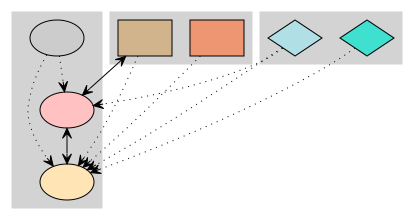

In [190]:
abstracted_graph('Microwave')

Alarm


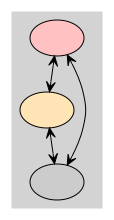

In [193]:
abstracted_graph('Alarm')

Kettle


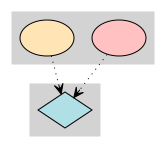

In [194]:
abstracted_graph('Kettle')

Microwave button press


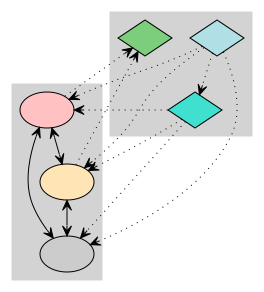

In [196]:
abstracted_graph('Microwave button press')